## Outline

Via is considering expanding its service area to include Astoria, Queens. We are trying to find the optimal way to launch this expansion.

We are using the NYC taxi data from the period before July 2016 (described and available here: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml, also available either through BiqQuery https://bigquery.cloud.google.com/table/imjasonh-storage:nyctaxi.trip_data, or in smaller samples from http://www.andresmh.com/nyctaxitrips/), to answer the following questions:

Analysis Questions:

1. How would we assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?

2. How does this compare to our current area of service (e.g. the Upper East Side)?

3. Would we provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why?

4. Would we launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?

Statistical Questions:

5. If given a metric for efficiency (assume we don't know how it's calculated), how to determine whether a specific zone is more efficient than the rest of the city? How would we determine why it’s more efficient?

6. How would we compare the distributions of intra-city trip prices between two different cities? How would we test whether any differences we find are explained by distance and duration?



  1. [Opening and Exploring the Test Data](#chapter-1)
      1. [Data Inspection](#chapter-1a)
      2. [Joining the Tables](#chapter-1b)
      3. [Distribution of the Data](#chapter-1c)
  2. [The Difference Between \$39 and \$59](#chapter-2)
      1. [Is the Difference Significant?](#chapter-2a)
  3. [Further Insights](#chapter-3)
      1. [Predicting Conversion](#chapter-3a)
  5. [Conclusions and Insights](#chapter-4)
      1. [Next Steps](#chapter-4a)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sqlalchemy import create_engine # database connection
from sqlalchemy.sql import text
import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

Data in 2013 August, 12,303,170 rides in total

In [4]:
disk_engine = create_engine('sqlite:///trip_data_2013.db')

In [5]:
print pd.read_sql_query('SELECT COUNT(*) FROM trip_data', disk_engine)

   COUNT(*)
0  12303170


In [7]:
zones = pd.read_csv("./taxi_zones/taxi_zone_lookup.csv")
zones.columns

Index([u'LocationID', u'Borough', u'Zone', u'service_zone'], dtype='object')

In [8]:
Manhattan_zones = zones[zones.Borough=="Manhattan"]["LocationID"].tolist()
Astoria_zones = zones[[row in ["Astoria", "Old Astoria", "Astoria Park"] for row in zones.Zone]]["LocationID"].tolist()
Laguardia_zones = zones[zones.Zone == "LaGuardia Airport"]["LocationID"].tolist()
Astoria_zones = zones[[row in ["Upper East Side North", "Upper East Side South"] for row in zones.Zone]]["LocationID"].tolist()

In [9]:
# query the rides information table for future use
query_taxi = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, 
                                dropoff_LocationID, medallion
                FROM trip_data'''
df_rides = pd.read_sql_query(query_taxi, disk_engine)

## Analysis questions:

**Question 1: How would you assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?**

In [10]:
# aggregating the rides within Astoria, between Astoria and LaGuardia, between Astoria and Manhattan
query_astoria = '''SELECT * 
                     FROM ( SELECT *, 
                       CASE WHEN pickup_LocationID IN ({astoria_ids}) 
                             AND dropoff_LocationID IN ({astoria_ids}) THEN "within_ast" 
                           WHEN pickup_LocationID IN ({astoria_ids}) 
                             AND dropoff_LocationID IN ({laguardia_ids}) THEN "from_lag_to_ast" 
                           WHEN pickup_LocationID IN ({laguardia_ids}) 
                             AND dropoff_LocationID IN ({astoria_ids}) THEN "from_ast_to_lag" 
                           WHEN pickup_LocationID IN ({manhattan_ids}) 
                             AND dropoff_LocationID IN ({astoria_ids}) THEN "from_man_to_ast"
                           WHEN pickup_LocationID IN ({astoria_ids})
                             AND dropoff_LocationID IN ({manhattan_ids}) THEN "from_ast_to_man" 
                           ELSE NULL 
                       END AS zones 
                       FROM trip_data )
                     WHERE zones IS NOT NULL '''
f = {"astoria_ids": ",".join([str(i) for i in Astoria_zones]), 
     "laguardia_ids": ",".join([str(i) for i in Laguardia_zones]), 
     "manhattan_ids": ",".join([str(i) for i in Manhattan_zones])}

In [11]:
df_Astoria = pd.read_sql_query(query_astoria.format(**f), disk_engine)

In [12]:
print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
print "within Astoria:                    ", len(df_Astoria[df_Astoria.zones=="within_ast"])
print "from Astoria to LaGuardia Airport: ", len(df_Astoria[df_Astoria.zones=="from_ast_to_lag"])
print "from LaGuardia Airport to Astoria: ", len(df_Astoria[df_Astoria.zones=="from_lag_to_ast"])
print "from Astoria to Manhattan:         ", len(df_Astoria[df_Astoria.zones=="from_ast_to_man"])
print "from Manhattan to Astoria:         ", len(df_Astoria[df_Astoria.zones=="from_man_to_ast"])

Number of Taxi Rides Between 2013-08-01 and 2013-08-31
within Astoria:                     131862
from Astoria to LaGuardia Airport:  6446
from LaGuardia Airport to Astoria:  6616
from Astoria to Manhattan:          547129
from Manhattan to Astoria:          525855


In [13]:
agg_Astoria = df_Astoria[['zones', 'passenger_count', 'trip_distance', 'trip_time', 'fare_amount']] \
                        .groupby(['zones']).mean().reset_index()

In [14]:
agg_Astoria["fare_per_minute"] = agg_Astoria["fare_amount"]/agg_Astoria["trip_time"]*60.0
agg_Astoria["dist_per_minute"] = agg_Astoria["trip_distance"]/agg_Astoria["trip_time"]*60.0

In [15]:
def plot_bar(df, x_cols, y_cols, titles):
    n_y = len(titles)/3 + 1
    plt.figure(figsize=(20,n_y*8))
    for i in range(len(titles)):
        plt.subplot(n_y, 3, i+1)
        sns.barplot(x=x_cols[i],y=y_cols[i],data=df)
        plt.xticks(rotation=10)
        plt.title(titles[i])

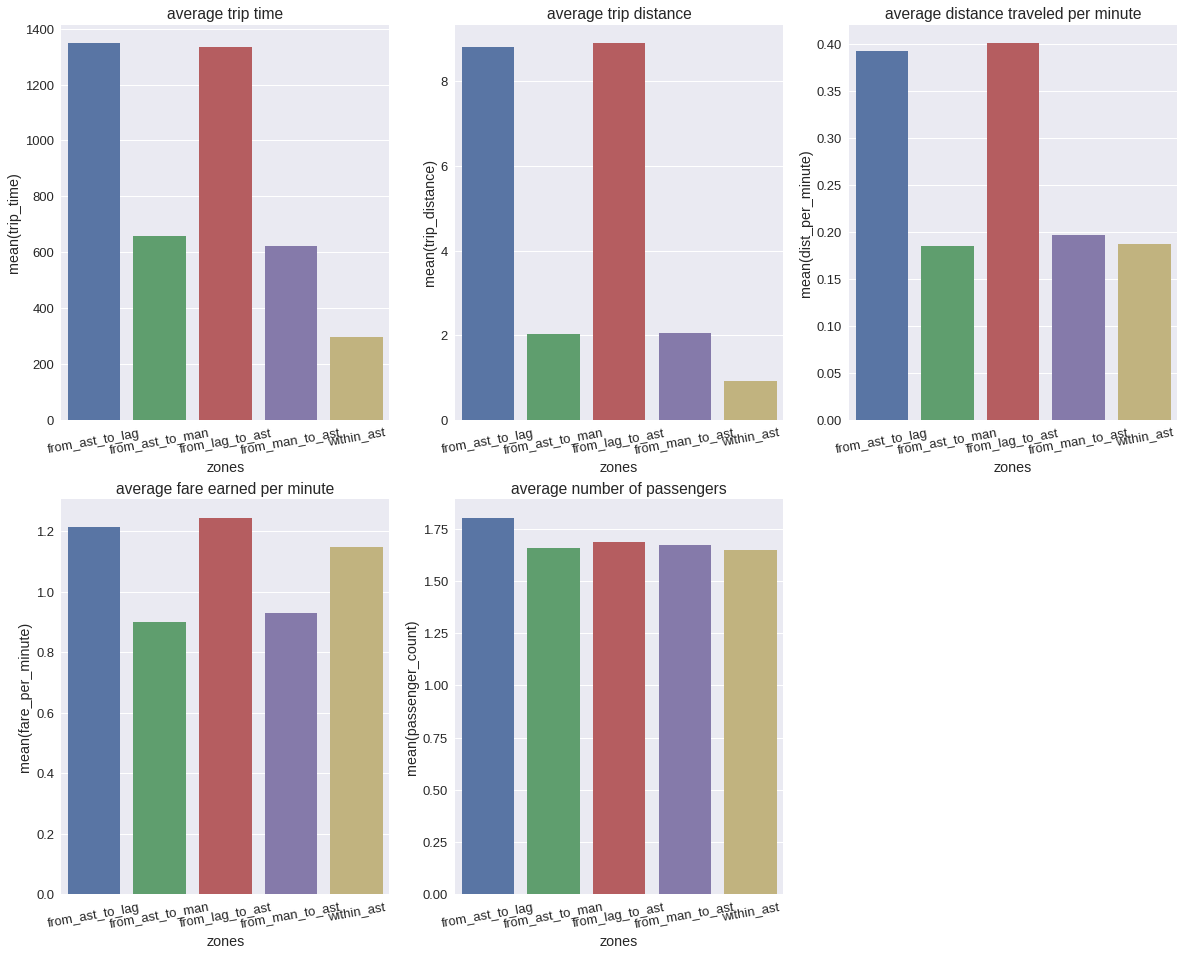

In [16]:
y_cols = ["trip_time", "trip_distance", "dist_per_minute", "fare_per_minute", "passenger_count"]
x_cols = ["zones"]*len(y_cols)
titles = ["average trip time", "average trip distance", "average distance traveled per minute",
          "average fare earned per minute", "average number of passengers"]

sns.set(font_scale=1.3)
plot_bar(agg_Astoria, x_cols, y_cols, titles)

The average waiting time for drivers dropping off at Astoria

In [17]:
# query the rides that end at Astoria
query_to_astoria = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, 
                                dropoff_LocationID, medallion, hack_license
                         FROM trip_data
                         WHERE dropoff_LocationID IN ({astoria_ids})'''
f = {"astoria_ids": ",".join([str(i) for i in Astoria_zones])}
df_to_astoria = pd.read_sql_query(query_to_astoria.format(**f), disk_engine)

In [18]:
print "Number of rides to Astoria: ", len(df_to_astoria)
print df_to_astoria.dtypes
df_to_astoria.head()

Number of rides to Astoria:  674841
pickup_datetime        object
dropoff_datetime       object
pickup_LocationID     float64
dropoff_LocationID    float64
medallion              object
hack_license           object
dtype: object


,pickup_datetime,dropoff_datetime,pickup_LocationID,dropoff_LocationID,medallion,hack_license
0,2013-08-30 17:43:38,2013-08-30 17:47:16,236.0,237.0,12842495074E45A2BDB93613AEBE05F3,FFF20BA1518E14B3B23F79DDDE1CA7E6
1,2013-08-29 19:17:22,2013-08-29 19:24:35,43.0,236.0,BD6BEC206DAB447D3D08AA2C3C75A53A,D425F45DE6E2271BA2EA9AB65BFA50D9
2,2013-08-26 11:24:38,2013-08-26 11:29:58,162.0,237.0,0D6EFD5154194976ECC7D1002693B7DF,6728F46F954A33E985F187B91FCBAA14
3,2013-08-30 00:20:14,2013-08-30 00:30:42,236.0,236.0,C4C347414D5C906720807BFC30CF13BA,262D54748AC4FE33D6BCAE268351FF80
4,2013-08-28 12:42:50,2013-08-28 12:47:35,236.0,236.0,F9E0A24870A77B6A347303BD68BF3081,48CAD00AF465E28CB1D0B0ABA6EDC90B


In [19]:
medallions = df_to_astoria.medallion.unique()

print len(medallions)

13252


In [30]:
import pickle
pickle.dump(medallions,open("medallions_ast_dropoff.txt","w"))

In [23]:
import dask.dataframe as dd
dask_rides=dd.from_pandas(df_rides, npartitions=15)

In [ ]:
df_rides_astoria = df_rides[[row in medallions for row in df_rides.medallion[:10]]]

In [213]:
df_rides_astoria = df_rides_astoria.sort_values(['pickup_datetime', 'dropoff_datetime'], ascending=[1, 1]) 
df_rides_astoria = df_rides_astoria.reset_index(drop=True)
df_rides_astoria.head()

,pickup_datetime,dropoff_datetime,pickup_LocationID,dropoff_LocationID,medallion,hack_license
0,2013-08-01 00:46:48,2013-08-01 00:57:37,144.0,229.0,12842495074E45A2BDB93613AEBE05F3,FFF20BA1518E14B3B23F79DDDE1CA7E6
1,2013-08-01 06:28:23,2013-08-01 06:35:32,224.0,161.0,12842495074E45A2BDB93613AEBE05F3,E856E630A472B79E379C9A08F988255C
2,2013-08-01 06:42:08,2013-08-01 06:47:31,170.0,90.0,12842495074E45A2BDB93613AEBE05F3,E856E630A472B79E379C9A08F988255C
3,2013-08-01 06:48:20,2013-08-01 06:53:05,90.0,230.0,12842495074E45A2BDB93613AEBE05F3,E856E630A472B79E379C9A08F988255C
4,2013-08-01 07:02:35,2013-08-01 07:15:52,48.0,107.0,12842495074E45A2BDB93613AEBE05F3,E856E630A472B79E379C9A08F988255C


In [ ]:
index = 0
df_wait_astoria = pd.DataFrame(columns = df_rides_astoria.columns.tolist() + ["wait_time"])
for index, row in df_rides_astoria.iterrows():
    if row.dropoff_LocationID in Astoria_zones:
        try:
            next_ride = df_rides_astoria[(df_rides_astoria.medallion == row["medallion"])].iloc[index+1]
        except:
            next_ride = []
        if len(next_ride) > 0:
            wait_time = (pd.to_datetime(next_ride.pickup_datetime) - pd.to_datetime(row["dropoff_datetime"])).total_seconds()/60.0

            if wait_time > 0 and wait_time < 600.0:
                row["wait_time"] = wait_time
                df_wait_astoria.loc[df_wait_astoria.shape[0]] = row   

In [ ]:
df_wait_astoria.describe()

**Question 2: How does this compare to our current area of service (e.g. the Upper East Side)?**

In [ ]:
# aggregating the rides within Upper East Side, between Upper East Side and LaGuardia, 
# between Upper East Side and Manhattan
query_upper_east = '''SELECT * 
                     FROM ( SELECT *, 
                       CASE WHEN pickup_LocationID IN ({upper_east_ids}) 
                             AND dropoff_LocationID IN ({upper_east_ids}) THEN "within_ues" 
                           WHEN pickup_LocationID IN ({upper_east_ids}) 
                             AND dropoff_LocationID = {laguardia_id} THEN "from_lag_to_ues" 
                           WHEN pickup_LocationID = {laguardia_id} 
                             AND dropoff_LocationID IN ({upper_east_ids}) THEN "from_ues_to_lag" 
                           WHEN pickup_LocationID IN ({manhattan_ids}) 
                             AND dropoff_LocationID IN ({upper_east_ids}) THEN "from_man_to_ues"
                           WHEN pickup_LocationID IN ({upper_east_ids})
                             AND dropoff_LocationID IN ({manhattan_ids}) THEN "from_ues_to_man"
                           ELSE NULL 
                       END AS zones 
                       FROM trip_data )
                     WHERE zones IS NOT NULL '''
f = {"upper_east_ids": ",".join([str(i) for i in [236, 237]]), 
     "laguardia_id": 138, 
     "manhattan_ids": ",".join([str(i) for i in Manhattan_zones])}

In [ ]:
df_upper_east = pd.read_sql_query(query_upper_east.format(**f), disk_engine)

In [ ]:
eff_Upper_East = df_upper_east[['zones', 'passenger_count', 'trip_distance', 'trip_time', 'fare_amount']] \
                        .groupby(['zones']).mean().reset_index()

In [ ]:
eff_Upper_East["fare_per_minute"] = eff_Upper_East["fare_amount"]/eff_Upper_East["trip_time"]*60.0
eff_Upper_East["dist_per_minute"] = eff_Upper_East["trip_distance"]/eff_Upper_East["trip_time"]*60.0

**Question 3. Would you provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why? For reference, Via started as a commuter service between the Upper East Side and Midtown.**

**Question 4. Would you launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?**

Statistical questions – answer these theoretically, no need to implement:
1. If you were given a metric for efficiency (assume you don't know how it's calculated), how would you determine whether a specific zone is more efficient than the rest of the city? How would you determine why it’s more efficient?
2. How would you compare the distributions of intra-city trip prices between two different cities? How would you test whether any differences you find are explained by distance and duration?
